In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.metrics import Mean
from keras.layers import BatchNormalization, Reshape, GlobalAveragePooling2D
from keras.layers import Dense, Conv2DTranspose, Input, Conv2D, Dropout, LeakyReLU, Flatten, ReLU
from keras.activations import relu, tanh
from keras.models import Model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

from IPython import display

import time

import cv2
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
import gdown
from zipfile import ZipFile

In [ ]:
os.makedirs('celeba_gan')

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)


'celeba_gan/data.zip'

In [ ]:
with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [ ]:
BATCH_SIZE = 128
img_height = 64
img_width = 64

In [ ]:
dir = '/content/celeba_gan/img_align_celeba'
dataset = tf.keras.utils.image_dataset_from_directory(directory = dir,
                                            labels = None,
                                            color_mode = 'rgb',
                                            batch_size = BATCH_SIZE,
                                            image_size = (img_height, img_width),
                                            shuffle = True,
                                            interpolation = 'bilinear'
                                           )
print(type(dataset))

Found 202599 files belonging to 1 classes.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [ ]:
for image_batch in dataset:
    print(image_batch.shape)
    print(len(image_batch))
    break

(128, 64, 64, 3)
128


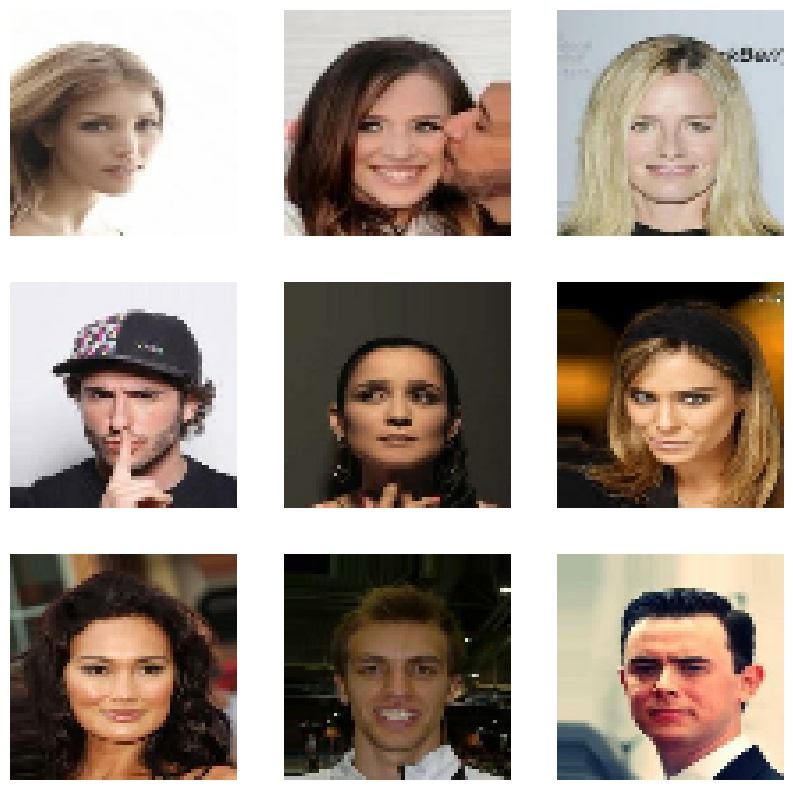

In [ ]:
plt.figure(figsize=(10,10))
for images in dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')

In [ ]:
#nomalize
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1.0)
normalized_ds = dataset.map(lambda x : normalization_layer(x))

In [ ]:
## Hyperparameters
latent_dim = 100

EPOCHS = 10

initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02, seed=20)


In [ ]:
#Generator model
def create_generator():
    model = keras.Sequential()
    model.add(Dense(2048, input_shape=(latent_dim,) ))
    model.add(Reshape((1,1,2048)))
    # (1,1,1024)
    model.add(Conv2DTranspose(1024, kernel_size=2, strides=1, padding='valid', kernel_initializer=initializer,
                              use_bias=True))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer,
                              use_bias=True))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer,
                              use_bias=True))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer,
                              use_bias=True))
    model.add(BatchNormalization())
    model.add(ReLU())


    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer,
                              use_bias=True))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', kernel_initializer=initializer,
                              use_bias=True))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', kernel_initializer=initializer,
                              use_bias=True, activation='tanh'))

    return model

In [ ]:
g_model = create_generator()
g_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2048)              206848    
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 2048)        0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 2, 2, 1024)       8389632   
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 2, 2, 1024)       4096      
 chNormalization)                                                
                                                                 
 re_lu_6 (ReLU)              (None, 2, 2, 1024)        0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 4, 4, 512)       

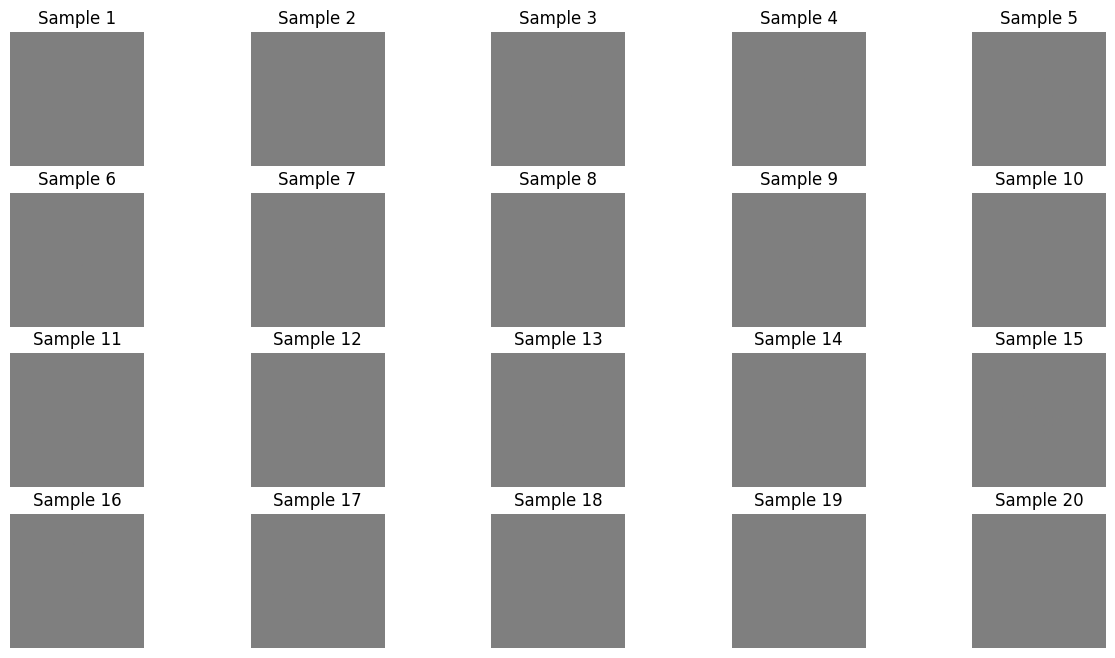

In [ ]:
noise = tf.random.normal([20, 100])
generated_images = g_model(noise, training=False)
generated_images = (generated_images + 1)/2 # convert the values from [-1,1] to [0,1] for plots

plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 4
columns = 5

for i in range(20) :
    image_index = i+1      # image index
    title = "Sample {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index) # subplot
    plt.title(title)   # title
    plt.axis('off')
    plt.xticks([])  # x = None
    plt.yticks([])  # y = None
    plt.imshow(generated_images[i])
plt.show()


In [ ]:
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(Conv2D(filters=64, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer, input_shape=[64,64,3]))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=initializer))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=1, kernel_size=4, strides=1, padding='valid', use_bias=False, kernel_initializer=initializer, activation='sigmoid'))
    model.add(Reshape((1,)))

    return model


In [ ]:
d_model = create_discriminator()
d_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                     

In [ ]:
new_noise = tf.random.normal([1, 100])
generated_new_image = g_model(new_noise, training=False)
decision = d_model(generated_new_image)
print(decision)

tf.Tensor([[0.50000435]], shape=(1, 1), dtype=float32)


In [ ]:
# loss_ftn
loss_ftn = BinaryCrossentropy()

In [ ]:
# optimizers
d_optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.5)
g_optimizer=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.5)

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_ftn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_ftn = loss_ftn
        self.d_loss_metric = Mean(name='d_loss')
        self.g_loss_metric = Mean(name='g_loss')


    def train_discriminator(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim,))
        generated_images = self.generator(noise)
        combined_images = tf.concat([real_images, generated_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size,1))], axis=0)

        with tf.GradientTape() as d_tape:
            d_output = self.discriminator(combined_images)
            d_loss = self.loss_ftn(labels, d_output)

        gradients_of_discriminator = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        D_x = tf.reduce_sum(d_output[:batch_size]) / tf.cast(batch_size, tf.float32)
        D_G_z_1 = tf.reduce_sum(d_output[batch_size:]) / tf.cast(batch_size, tf.float32)

        return d_loss

    def train_generator(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, self.latent_dim,])
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as g_tape:
            generated_images = self.generator(noise)
            g_output = self.discriminator(generated_images)
            g_loss = self.loss_ftn(misleading_labels, g_output)

        gradients_of_generator = g_tape.gradient(g_loss, self.generator.trainable_variables)
        g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        D_G_z_2 = tf.reduce_sum(g_output) / tf.cast(batch_size, tf.float32)

        return g_loss

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim,))
        generated_images = self.generator(noise)
        combined_images = tf.concat([real_images, generated_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size,1))], axis=0)
        d_output = self.discriminator(combined_images)
        D_x = tf.reduce_sum(d_output[:batch_size]) / tf.cast(batch_size, tf.float32)
        D_G_z_1 = tf.reduce_sum(d_output[batch_size:]) / tf.cast(batch_size, tf.float32)

        d_loss = tf.cond(tf.logical_and(D_x>=tf.constant(0.75), D_G_z_1<=0.40), true_fn=lambda: self.loss_ftn(labels, d_output) ,false_fn=lambda: self.train_discriminator(real_images))


        noise = tf.random.normal([batch_size, self.latent_dim,])
        generated_images = self.generator(noise)
        misleading_labels = tf.ones((batch_size, 1))
        g_output = self.discriminator(generated_images)
        D_G_z_2 = tf.reduce_sum(g_output) / tf.cast(batch_size, tf.float32)

        g_loss = tf.cond(D_G_z_2>=tf.constant(0.8), true_fn=lambda: self.loss_ftn(misleading_labels, g_output), false_fn=lambda: self.train_generator(real_images))



        return {
            'd_loss' : d_loss,
            'g_loss' : g_loss,
            'D_x' : D_x,
            'D_G_z_1' : D_G_z_1,
            'D_G_z_2' : D_G_z_2
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=9, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def createfolder(self, directory):
        try:
            if not os.path.exists(directory):
                os.makedirs(directory)
        except OSError:
            print('Error: Creating directory. ' + directory)

    def on_epoch_end(self, epoch, logs=None):
        self.createfolder('./generated_images')
        noise = tf.random.normal((self.num_img, self.latent_dim))
        generated_images = self.model.generator(noise)
        generated_images = (generated_images + 1)/2
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save('./generated_images/generated_img_%03d_%d.png' % (epoch, i))

In [ ]:
epochs = 20  # In practice, use ~100 epochs

gan = GAN(discriminator=d_model, generator=g_model, latent_dim=latent_dim)
gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_ftn=loss_ftn,
)

history = gan.fit(
    normalized_ds, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/20
1583/1583 [==============================] - 565s 355ms/step - d_loss: 0.5961 - g_loss: 2.1287 - D_x: 0.8133 - D_G_z_1: 0.2670 - D_G_z_2: 0.1208
Epoch 2/20
1583/1583 [==============================] - 630s 398ms/step - d_loss: 0.6951 - g_loss: 2.2382 - D_x: 0.6991 - D_G_z_1: 0.3544 - D_G_z_2: 0.1512
Epoch 3/20
1583/1583 [==============================] - 636s 402ms/step - d_loss: 0.3245 - g_loss: 2.7859 - D_x: 0.6810 - D_G_z_1: 0.3583 - D_G_z_2: 0.1558
Epoch 4/20
1583/1583 [==============================] - 663s 418ms/step - d_loss: 0.5882 - g_loss: 1.5179 - D_x: 0.6238 - D_G_z_1: 0.3925 - D_G_z_2: 0.1957
Epoch 5/20
1583/1583 [==============================] - 664s 419ms/step - d_loss: 0.7530 - g_loss: 1.8351 - D_x: 0.6307 - D_G_z_1: 0.3835 - D_G_z_2: 0.2052
Epoch 6/20
1583/1583 [==============================] - 664s 419ms/step - d_loss: 0.6859 - g_loss: 2.2174 - D_x: 0.6578 - D_G_z_1: 0.3567 - D_G_z_2: 0.1904
Epoch 7/20
1583/1583 [==============================] - 666s 420

loss로 treshold를 한 번 만들어보자

In [ ]:
new_noise = tf.random.normal([30, latent_dim,])
misleading = tf.ones((30, 1))
with tf.GradientTape() as g_tape0:
    new_generated_imgs = g_model(new_noise)
    predict_g_output = d_model(new_generated_imgs)
    g_loss_0 = loss_ftn(misleading, predict_g_output)
print(predict_g_output)
D_G_z_2_0 = tf.reduce_sum(predict_g_output) / tf.cast(30, tf.float32)
print('D_G_z_0:', D_G_z_2_0)
print('g_loss_0:', g_loss_0)

# noise = tf.random.normal([batch_size, self.latent_dim,])
# misleading_labels = tf.ones((batch_size, 1))
# generated_images = self.generator(noise, training=True)
# g_output = self.discriminator(generated_images, training=False)
# g_loss = self.loss_ftn(misleading_labels, g_output)
# D_G_z_2 = tf.reduce_sum(g_output) / tf.cast(batch_size, tf.float32)
#         with tf.GradientTape() as g_tape:
            # d_model.trainable=False
            # generated_images = self.generator(noise, training=True)
            # g_output = self.discriminator(generated_images, training=False)
            # g_loss = self.loss_ftn(misleading_labels, g_output)

tf.Tensor(
[[0.14171357]
 [0.03607771]
 [0.05843443]
 [0.0626249 ]
 [0.1482108 ]
 [0.56742644]
 [0.5578995 ]
 [0.03777485]
 [0.0500406 ]
 [0.03898264]
 [0.03379053]
 [0.22934014]
 [0.03137566]
 [0.0102174 ]
 [0.00770228]
 [0.01575587]
 [0.05843383]
 [0.02901025]
 [0.03087401]
 [0.41187626]
 [0.04083096]
 [0.6041047 ]
 [0.7020495 ]
 [0.19415945]
 [0.11224666]
 [0.01429202]
 [0.6920512 ]
 [0.44047183]
 [0.6874389 ]
 [0.02132744]], shape=(30, 1), dtype=float32)
D_G_z_0: tf.Tensor(0.2022178, shape=(), dtype=float32)
g_loss_0: tf.Tensor(2.4556448, shape=(), dtype=float32)


In [ ]:
for image_batch in normalized_ds:
    predicts = d_model(image_batch[:30,:,:,:])
    print(predicts)
    D_x_0 = tf.reduce_sum(predicts) / tf.cast(30, tf.float32)
    print(D_x_0)
    d_loss_0 = loss_ftn(misleading, predicts)
    print(d_loss_0)
    break

tf.Tensor(
[[0.03775285]
 [0.03364973]
 [0.99985385]
 [0.00687966]
 [0.01844659]
 [0.96452934]
 [0.10751734]
 [0.9408631 ]
 [0.89084417]
 [0.02705929]
 [0.35177293]
 [0.52267265]
 [0.9590886 ]
 [0.03705816]
 [0.02773116]
 [0.15305994]
 [0.3617833 ]
 [0.234786  ]
 [0.99999964]
 [0.18512164]
 [0.16093433]
 [0.06472699]
 [0.2017232 ]
 [0.00783318]
 [0.25578752]
 [0.33197036]
 [0.0491332 ]
 [0.9341941 ]
 [0.02932838]
 [0.99649954]], shape=(30, 1), dtype=float32)
tf.Tensor(0.3630867, shape=(), dtype=float32)
tf.Tensor(1.8811014, shape=(), dtype=float32)


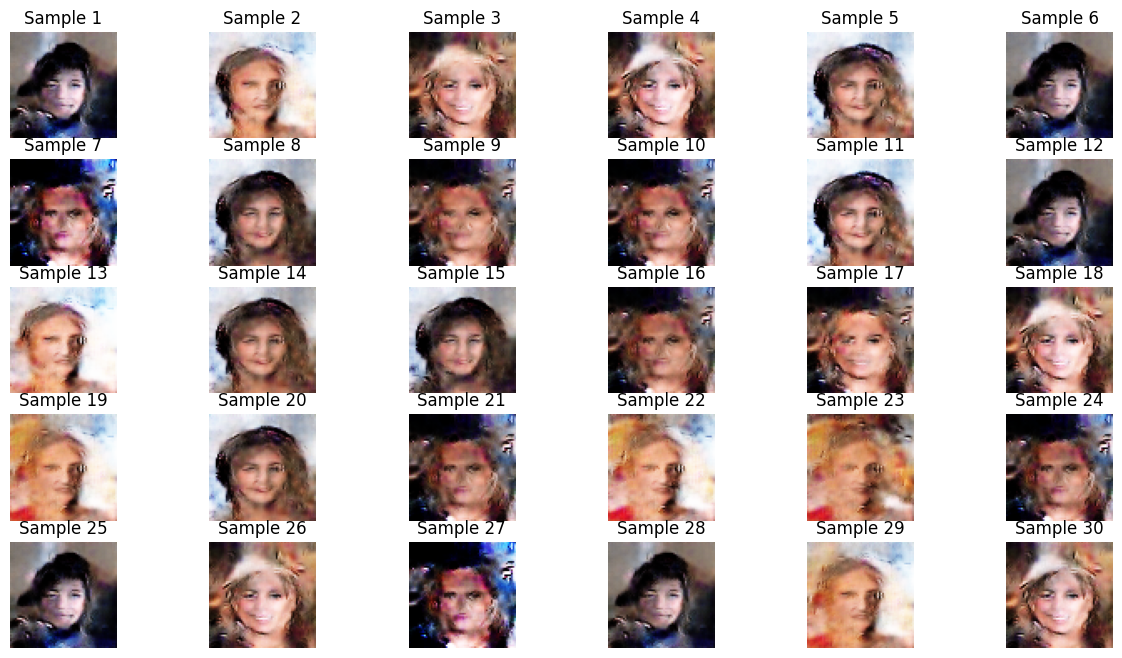

In [ ]:
new_noise = tf.random.normal([30, latent_dim])
new_generated_imgs = g_model(new_noise)
new_generated_imgs = (new_generated_imgs + 1)/2

plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 5
columns = 6

for i in range(30) :
    image_index = i+1      # image index
    title = "Sample {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index) # subplot
    plt.title(title)   # title
    plt.axis('off')
    plt.xticks([])  # x = None
    plt.yticks([])  # y = None
    plt.imshow(new_generated_imgs[i])
plt.show()